In [22]:
import pandas as pd
import polars as pl
import numpy as np
import random
from tqdm import tqdm
from xgboost import XGBClassifier,  plot_importance
import xgboost
import os
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

In [26]:
np.random.seed(42)
DATA_PATH = "../cloudswithtime/"

## Data preparation

In [27]:
def train_test_split(folderpath, testsplit=0.3):
    files = [f for f in os.listdir(folderpath) if os.path.isfile(os.path.join(folderpath, f))]
    np.random.shuffle(files)
    
    split = int(len(files)*(1-testsplit))
    trainFiles = files[:split]
    testFiles = files[split:]

    return trainFiles, testFiles

In [28]:
trainFiles, testFiles = train_test_split(f"{DATA_PATH}")

In [29]:
print(len(trainFiles))

3193


## Training

In [30]:
xgb = XGBClassifier(n_estimators = 100, tree_method='gpu_hist', n_jobs = -1)

for i in tqdm(trainFiles):
    df = pd.read_parquet(f"{DATA_PATH}{i}")
    
    xgb.fit(df[['x', 'y', 'z', 'DBZH', 'VRADH', 'prior_DBZ', 'prior_VRAD']], df[['biology']])

100%|██████████████████████████████████████████████████████████████████████████████| 3193/3193 [35:18<00:00,  1.51it/s]


## Testing

In [31]:
cms = {}
j = 0

accuracies = []
precisions = []
recalls = []

for i in tqdm(testFiles):
    df = pd.read_parquet(f"{DATA_PATH}{i}")
    
    predictions = xgb.predict(df[['x', 'y', 'z', 'DBZH', 'VRADH', 'prior_DBZ', 'prior_VRAD']])
    
    cms[j] = confusion_matrix(df[['biology']], predictions)
    
    acc = accuracy_score(df[['biology']], predictions)
    prec = precision_score(df[['biology']], predictions)
    rec = recall_score(df[['biology']], predictions)
    
    accuracies.append(acc)
    precisions.append(prec)
    recalls.append(rec)
    
    #print(f"Accuracy: {acc}")
    #print(f"Precision: {prec}")
    #print(f"Recall: {rec}")
    #print("--------------------")
    j+=1
    
print(f"Average Accuracy: {np.mean(accuracies)}")
print(f"Min Accuracy: {np.min(accuracies)}")
print(f"Max Accuracy: {np.max(accuracies)}\n")
print(f"Average Precision: {np.mean(precisions)}")
print(f"Min Precision: {np.min(precisions)}")
print(f"Max Precision: {np.max(precisions)}\n")
print(f"Average Recall: {np.mean(recalls)}")
print(f"Min Recall: {np.min(recalls)}")
print(f"Max Recall: {np.max(recalls)}")

100%|██████████████████████████████████████████████████████████████████████████████| 1369/1369 [14:03<00:00,  1.62it/s]

Average Accuracy: 0.7768669843369755
Min Accuracy: 0.5217104777946694
Max Accuracy: 0.8820032702288355

Average Precision: 0.7690375248467849
Min Precision: 0.18550871057573992
Max Precision: 0.9212579451431663

Average Recall: 0.8125244601748335
Min Recall: 0.4021046422971243
Max Recall: 0.9768490050109246


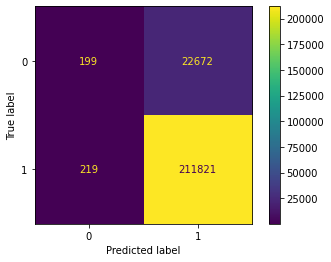

In [20]:
disp = ConfusionMatrixDisplay(cms[497])
disp.plot()
plt.show()

## Feature Importance

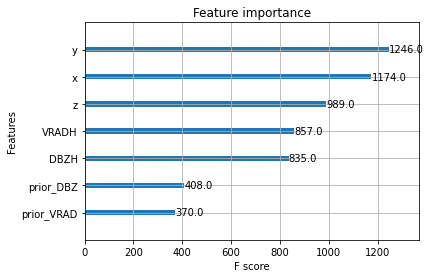

In [32]:
plot_importance(xgb)
plt.show()

## Converting single pointcloud to predicted csv

In [ ]:
df = pd.read_parquet(f"../cloudswithtime/NLHRW_pvol_20211008T1510_6356.parquet")
df['preds'] = xgb.predict(df[['x', 'y', 'z', 'DBZH', 'VRADH', 'prior_DBZ', 'prior_VRAD']])
df.to_csv("../notable clouds/highest_rec.csv")

## Saving the model

In [33]:
xgb.save_model("../models/XGBTime.ubj")

### Extra

In [ ]:
rand_clouds = np.random.choice(testFiles[:400], 5)
print(rand_clouds)

for i, cl in enumerate(rand_clouds):
    df = pd.read_parquet(f"../cloudswithtime/{cl}")
    df['preds'] = xgb.predict(df[['x', 'y', 'z', 'DBZH', 'VRADH', 'prior_DBZ', 'prior_VRAD']])
    df.to_csv(f"../notable clouds/random_{i}.csv")